In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time

from matplotlib.path import Path
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from cell_utilities import *

/oasis/projects/nsf/csd395/yuncong/brain_virtualenv/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for Gordon


No vtk
Cannot import mxnet.


In [2]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
from xgboost.sklearn import XGBClassifier

In [3]:
structures_to_sample = all_known_structures

negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

margins_to_sample = [500] # (100 um, 250 um)
surround_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                             for m in margins_to_sample
                             for s in structures_to_sample 
                             for surr_l in structures_to_sample + ['noclass'] 
                             if surr_l != s]

labels_to_sample = structures_to_sample + negative_labels_to_sample + surround_labels_to_sample + ['noclass']

# Generate Test Dataset

In [5]:
training_addresses_by_section = []

for stack in all_annotated_nissl_stacks:
# for stack in ['MD585']:
    first_sec, last_sec = metadata_cache['section_limits'][stack]
    
    t1 = time.time()
    
    contours_df = read_hdf(ANNOTATION_ROOTDIR + '/%(stack)s/%(stack)s_annotation_v3.h5' % dict(stack=stack), 'contours')
    labeled_contours = contours_df[(contours_df['orientation'] == 'sagittal') & (contours_df['downsample'] == 1)]
    labeled_contours = labeled_contours.drop_duplicates(subset=['section', 'name', 'side', 'filename', 'downsample', 'creator'])
    labeled_contours = convert_annotation_v3_original_to_aligned_cropped(labeled_contours, stack=stack)
    
    sys.stderr.write('Load annotation. Time: %.2s seconds.\n' % (time.time() - t1))
    
    def label_region_worker(sec):
    
        training_addresses = {}

        if is_invalid(stack=stack, sec=sec):
            return

        region_contours = bp.unpack_ndarray_file(get_cell_classifier_data_filepath(what='region_contours', stack=stack, sec=sec, ext='bp'))
        region_labels = label_regions(stack=stack, section=sec, region_contours=region_contours,
                                      surround_margins=margins_to_sample,
                                      labeled_contours=labeled_contours[labeled_contours['section'] == sec])

        for label, region_indices in region_labels.iteritems():
            if label == 'bg' or len(region_indices) == 0:
                continue
            sampled_region_indices = np.random.choice(region_indices, min(3, len(region_indices)), replace=False)
            training_addresses[label] = [(stack, sec, ridx) for ridx in sampled_region_indices]

        return training_addresses
    
    t1 = time.time()
    
    pool = Pool(15)
    training_addresses_by_section_curr_stack = pool.map(lambda sec: label_region_worker(sec), range(first_sec, last_sec+1))
    pool.close()
    pool.join()
    
    training_addresses_by_section += training_addresses_by_section_curr_stack
    
    sys.stderr.write('Sample training addresses. Time: %.2s seconds.\n' % (time.time() - t1))
    
    
t = time.time()

training_addresses = defaultdict(list)
for train_addrs_by_label in training_addresses_by_section:
    if train_addrs_by_label is None: continue
    for label, addrs in train_addrs_by_label.iteritems():
        training_addresses[label] += addrs

sys.stderr.write('Time: %.2f seconds.\n' % (time.time() - t)) # 200s / stack

Load annotation. Time: 2. seconds.
Analyzing section 93..
Analyzing section 88..
Analyzing section 113..
Analyzing section 98..
Analyzing section 108..
Analyzing section 123..
Analyzing section 148..
Analyzing section 153..
Analyzing section 133..
Analyzing section 83..
Analyzing section 143..
Analyzing section 128..
Analyzing section 138..
Analyzing section 119..
Analyzing section 103..
Analyzing section 84..
Analyzing section 89..
Analyzing section 85..
Analyzing section 94..
Analyzing section 99..
Analyzing section 104..
Analyzing section 114..
Analyzing section 90..
Analyzing section 86..
Analyzing section 120..
Analyzing section 124..
Analyzing section 109..
Analyzing section 95..
Analyzing section 87..
Analyzing section 100..
Analyzing section 134..
Analyzing section 129..
Analyzing section 91..
Analyzing section 105..
Analyzing section 158..
Analyzing section 115..
Analyzing section 139..
Analyzing section 121..
Analyzing section 96..
Analyzing section 125..
Analyzing section 11

In [6]:
for label, train_addrs in training_addresses.iteritems():
    print label, len(train_addrs)

Amb_surround_500_7N 13
12N_surround_500_AP 22
4N_negative 138
RtTg_negative 540
Tz_negative 447
SNC_surround_500_SNR 753
SNR_surround_500_SNC 414
SC_surround_500_IC 1368
5N 414
Sp5I_surround_500_Sp5C 168
VCP_surround_500_noclass 438
Sp5I_surround_500_Sp5O 297
LRt_negative 504
6N_surround_500_7n 27
12N 348
3N_surround_500_noclass 216
6N_negative 159
LC_negative 201
VCA_surround_500_VCP 312
Pn_surround_500_noclass 870
Sp5I 372
VCA_surround_500_noclass 570
Sp5C_surround_500_noclass 714
12N_surround_500_noclass 348
3N_surround_500_4N 9
SNC 414
SNR_surround_500_PBG 9
Amb_negative 108
LC_surround_500_noclass 201
4N_surround_500_3N 69
DC_surround_500_VCA 309
7n_negative 1131
DC_surround_500_VCP 346
noclass 2406
SNC_surround_500_noclass 753
AP_negative 150
RtTg 540
Pn 837
RMC_negative 537
10N 84
VLL 564
LRt_surround_500_Sp5C 37
RtTg_surround_500_Tz 132
VCP_negative 438
SNC_negative 753
IC_surround_500_noclass 1392
PBG_surround_500_noclass 246
Sp5O_negative 306
SNR 1065
Pn_surround_500_Tz 2
PBG

In [7]:
def load_features_(stack, section, region_indices):
    """
    """
    
    region_features_all_regions = load_hdf_v2(get_cell_classifier_data_filepath(what='region_features', stack=stack, sec=section, ext='hdf'))
    # Loading hdf ~ 2 seconds.
    
    features1 = np.asarray([rf['largeOrientationHist'] for rf in region_features_all_regions])
    features2 = np.asarray([rf['largeSizeHist'] for rf in region_features_all_regions])
    features3 = np.asarray([rf['largeLargeLinkLenHist'] for rf in region_features_all_regions])
    features4 = np.asarray([rf['largeSmallLinkLenHist'] for rf in region_features_all_regions])
    
        
    f1 = features1[region_indices]
    f1n = f1/f1.sum(axis=1)[:,None].astype(np.float)
    
    f2 = features2[region_indices]
    f2n = f2/f2.sum(axis=1)[:,None].astype(np.float)
    
    f3 = features3[region_indices]
    f3n = f3/f3.sum(axis=1)[:,None].astype(np.float)
    
    f4 = features4[region_indices]
    f4n = f4/f4.sum(axis=1)[:,None].astype(np.float)
    
    features = np.c_[f1n, f2n, f3n, f4n]
    
    return features

In [8]:
t = time.time()

func_for_list = lambda addrs: smart_map(addrs, keyfunc=lambda (st, se, ri): (st, se),
                       func=lambda (st, se), gr: load_features_(st, se, [ri for _,_,ri in gr]))

training_features = apply_function_to_dict(func_for_list, 
                                           training_addresses)
#                        {i: t for i, t in training_addresses.iteritems() if i in ['7N', '5N']})

training_features = apply_function_to_dict(np.asarray, training_features)

sys.stderr.write('Load features: %.2f seconds.\n' % (time.time() - t)) # 35 seconds

Load features: 123.42 seconds.


In [9]:
# Remove features with invalid values.

training_addresses_invalid_removed = {}
training_features_invalid_removed = {}
for label, feats in training_features.iteritems():
    invalid_indices = np.where(np.any(np.isnan(feats), axis=1))[0]
    print label, len(invalid_indices), 'invalid'
    valid_indices = np.setdiff1d(np.arange(len(feats)), invalid_indices)
    
    training_addresses_invalid_removed[label] = [training_addresses[label][i] for i in valid_indices]
    training_features_invalid_removed[label] = training_features[label][valid_indices]    

Amb_surround_500_7N 0 invalid
12N_surround_500_AP 2 invalid
4N_negative 23 invalid
AP_negative 26 invalid
Tz_negative 69 invalid
SNC_surround_500_SNR 34 invalid
SNR_surround_500_SNC 10 invalid
SC_surround_500_IC 6 invalid
5N 2 invalid
Sp5I_surround_500_Sp5C 0 invalid
SNC_surround_500_noclass 23 invalid
Sp5I_surround_500_Sp5O 0 invalid
LRt_negative 72 invalid
6N_surround_500_7n 16 invalid
12N 3 invalid
3N_surround_500_noclass 11 invalid
6N_negative 25 invalid
LC_negative 27 invalid
VCA_surround_500_VCP 0 invalid
Pn_surround_500_noclass 116 invalid
Sp5I 0 invalid
VCA_surround_500_noclass 90 invalid
Sp5C_surround_500_noclass 19 invalid
12N_surround_500_noclass 23 invalid
3N_surround_500_4N 0 invalid
SNC 10 invalid
SNR_surround_500_PBG 0 invalid
Amb_negative 12 invalid
LC_surround_500_noclass 2 invalid
4N_surround_500_3N 1 invalid
DC_surround_500_VCA 0 invalid
7n_negative 138 invalid
DC_surround_500_VCP 3 invalid
noclass 517 invalid
RtTg 13 invalid
Pn 39 invalid
RMC_negative 77 invalid
10N

In [10]:
training_addresses = training_addresses_invalid_removed
training_features = training_features_invalid_removed

In [11]:
# Save this set as dataset.

dataset = 6

train_feat_dir = create_if_not_exists(os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'region_features'))

# Save training features
for label, feats in training_features.iteritems():
    bp.pack_ndarray_file(feats, os.path.join(train_feat_dir, label + '.bp'))
    
# Save training addresses
save_pickle(training_addresses, os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'region_addresses.pkl'))

# Load dataset

In [73]:
dataset = 9
train_feat_dir = create_if_not_exists(os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'region_features'))

In [74]:
# Load training features

training_features = {}
for label in labels_to_sample:
    try:
        training_features[label] = bp.unpack_ndarray_file(os.path.join(train_feat_dir, label + '.bp'))
    except:
        continue

In [75]:
labels_found = training_features.keys()
structures_found = set([convert_to_original_name(l) for l in labels_found]) - {'noclass'}

# Load pre-computed classifiers

In [76]:
setting = 21
setting_dir = os.path.join(os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'setting_%d' % setting))
margin = 500

In [77]:
clf_allClasses = {}
for structure in structures_to_sample:
    clf_fp = os.path.join(setting_dir, 'classifiers', '%(structure)s_clf_setting_%(setting)d.dump' % {'structure': structure, 'setting':setting})
    if os.path.exists(clf_fp):
        clf_allClasses[structure] = joblib.load(clf_fp)
    else:
        sys.stderr.write('No classifier for %s is found.\n' % structure)

No classifier for sp5 is found.
No classifier for outerContour is found.


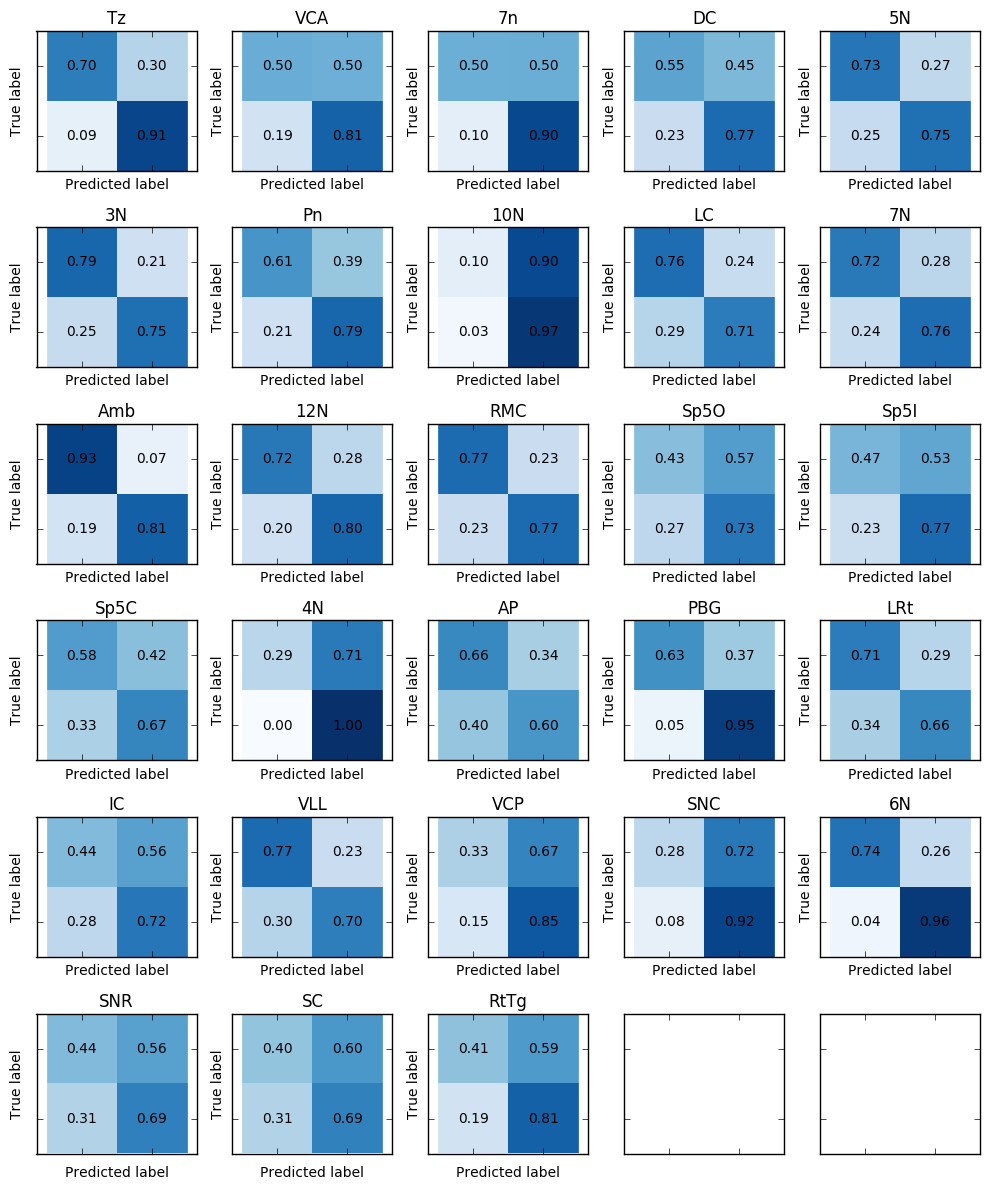

In [78]:
# Compute training accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
    if setting in [1, 3, 4, 5, 6, 7]:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
    elif setting in [2, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]            
        for surr_l in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_l)
            if c in labels_found:
                neg_classes.append(c)
    elif setting in [8,9,11]:
        neg_classes = [structure + '_negative']
    else:
        sys.stderr.write('Setting is not recognized.\n')
        raise

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
#     neg_distances = np.concatenate([distances_to_structures[neg_class][label] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
    
    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(train_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in train_labels], soft=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s'% {'structure':structure},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [79]:
print [' '.join([n, '%.2f'%a]) for n, a in sorted(acc_all_structures.items())]

['10N 0.97', '12N 0.76', '3N 0.77', '4N 0.92', '5N 0.74', '6N 0.92', '7N 0.74', '7n 0.84', 'AP 0.62', 'Amb 0.86', 'DC 0.69', 'IC 0.62', 'LC 0.73', 'LRt 0.68', 'PBG 0.82', 'Pn 0.72', 'RMC 0.77', 'RtTg 0.66', 'SC 0.58', 'SNC 0.84', 'SNR 0.58', 'Sp5C 0.63', 'Sp5I 0.68', 'Sp5O 0.63', 'Tz 0.83', 'VCA 0.70', 'VCP 0.71', 'VLL 0.74']


In [80]:
structures_sorted_by_size = ['4N', '6N', 'Amb', 'PBG', '10N', 'AP', '3N', 'LC', 'SNC', 'Tz', '7n', 'RMC', '5N', 'VCP', '12N', 'LRt', '7N', 'VCA', 'VLL', 'DC', 'Sp5O', 'Sp5I', 'Pn', 'RtTg', 'SNR', 'Sp5C', 'IC', 'SC']

x =[[s] if s in singular_structures else [convert_to_left_name(s), convert_to_right_name(s)] for s in structures_sorted_by_size]
structures_sided_sorted_by_size = [j for i in x for j in i ]
print structures_sided_sorted_by_size

['4N_L', '4N_R', '6N_L', '6N_R', 'Amb_L', 'Amb_R', 'PBG_L', 'PBG_R', '10N_L', '10N_R', 'AP', '3N_L', '3N_R', 'LC_L', 'LC_R', 'SNC_L', 'SNC_R', 'Tz_L', 'Tz_R', '7n_L', '7n_R', 'RMC_L', 'RMC_R', '5N_L', '5N_R', 'VCP_L', 'VCP_R', '12N', 'LRt_L', 'LRt_R', '7N_L', '7N_R', 'VCA_L', 'VCA_R', 'VLL_L', 'VLL_R', 'DC_L', 'DC_R', 'Sp5O_L', 'Sp5O_R', 'Sp5I_L', 'Sp5I_R', 'Pn_L', 'Pn_R', 'RtTg', 'SNR_L', 'SNR_R', 'Sp5C_L', 'Sp5C_R', 'IC', 'SC']


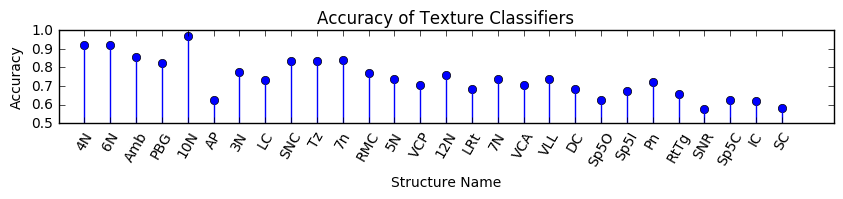

In [81]:
plt.figure(figsize=(10,1.2));
plt.stem(range(1,1+len(acc_all_structures)), [acc_all_structures[s] for s in structures_sorted_by_size]);
plt.xticks(range(1, 1+len(acc_all_structures)), structures_sorted_by_size, rotation='60');
plt.ylim([0.5, 1]);
plt.ylabel('Accuracy');
plt.xlabel('Structure Name');
plt.title('Accuracy of Texture Classifiers')
plt.show();

In [82]:
print 'test accuracy:', np.mean(acc_all_structures.values())

test accuracy: 0.740819182794
